In [14]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import (Lambda, Input, Reshape,
                          Dense, 
                          Conv2D, Conv2DTranspose,
                          Flatten, MaxPool2D,)
from keras.losses import mse, mae, binary_crossentropy
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import keras.backend as K

In [2]:
def settrainable(model, toset):
    for layer in model.layers:
        layer.trainable = toset
    model.trainable = toset

In [3]:
labels = np.random.uniform(0,2,100)
labels[3] = None

In [21]:
def gen_petal_gmm(labels,dims=2):
    labels = np.array(labels,dtype=int)
    n_labels = np.max(labels)+1
    vectors = []
    for idx,label in enumerate(labels):
        if label == -1:
            l = np.random.randint(0, n_labels)
        else:
            l = label
        mean = [n_labels*np.cos((l*2*np.pi)/n_labels), n_labels*np.sin((l*2*np.pi)/n_labels)]
        v1 = [np.cos((l*2*np.pi)/n_labels), np.sin((l*2*np.pi)/n_labels)]
        v2 = [-np.sin((l*2*np.pi)/n_labels), np.cos((l*2*np.pi)/n_labels)]
        a1 = n_labels*0.8
        a2 = n_labels*0.02
        M =np.vstack((v1,v2)).T
        S = np.array([[a1, 0], [0, a2]])
        cov = np.dot(np.dot(M, S), np.linalg.inv(M))
        #cov = cov*cov.T
        vec = np.random.multivariate_normal(mean=mean, cov=cov,
                                            size=1)
        vectors.append(vec)
    return np.array(vectors)

In [24]:
labels = np.random.randint(-1,25,100000)
samps = gen_petal_gmm(labels)

<IPython.core.display.Javascript object>


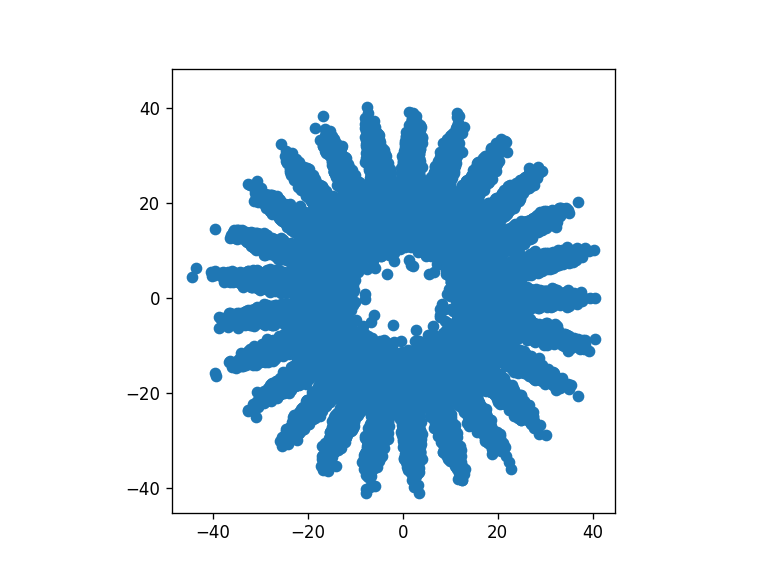

(-48.6397361006218, 44.7745201208176, -45.220531374483706, 48.193724846955696)

In [25]:
%matplotlib notebook
plt.scatter(samps[:,0,0],samps[:,0,1])
plt.axis('square')

In [3]:
input_shape = (1024,1,1) # if you want 1D fft inputs, make the input_shape (nfft,1,1)
filters = 1
layers = 2
kernel_size = [5,5]
strides = [2,2]
dilation = [1,1]
intermediate = 16
latent_dim = 4

inputs = Input(shape=input_shape)
x = inputs
for i in range(layers):
    filters *= 2
    x = Conv2D(filters,
               kernel_size=kernel_size,
               strides=strides,
               dilation_rate=dilation,
               activation='relu',
               padding='same')(x)


# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(intermediate, activation='relu')(x)
z = Dense(latent_dim, name='z')(x)

# no reparameterization trick here, since we will get the distribution
#   through adversarial training against a stocastic process we don't
#   need to sample here

encoder = Model(inputs, z, name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 1, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 1, 2)         52        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 1, 4)         204       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                16400     
_________________________________________________________________
z (Dense)                    (None, 4)                 68        
Total params: 16,724
Trainable params: 16,724
Non-trainable params: 0


In [4]:
# for a symetric decoder, all of the parameters have already been
#     declared in the encoder definition
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(layers):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        activation='relu',
                        padding='same')(x)
    filters //= 2

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    activation='relu', # we may need to play with this, the keras example has sigmoid
                    padding='same',
                    name='decoder_output')(x)

# if 1D input we need to maxpool dim 2 to collapse the extra bins the Transpose conv2D put in that dimension
if input_shape[1]==1:
    out_shape = K.int_shape(x)
    outputs = MaxPool2D(pool_size=(1,out_shape[2]), strides=None, padding='valid')(x)
else:
    outputs = x

decoder = Model(latent_inputs,outputs)
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5120      
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 1, 4)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 512, 2, 4)         404       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 1024, 4, 2)        202       
_________________________________________________________________
decoder_output (Conv2DTransp (None, 1024, 4, 1)        51        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1024, 1, 1)        0         
Total para

Build the discriminator

In [5]:
disc_dim = 32
disc_inputs = Input(shape=(latent_dim,), name='disc_input')
x = disc_inputs
x = Dense(disc_dim, activation='relu')(x)
x = Dense(disc_dim, activation='relu')(x)
disc_outputs = Dense(1,activation='sigmoid')(x)

discriminator = Model(disc_inputs,disc_outputs)
discriminator.compile(optimizer=Adam(lr=1e-4), 
                      loss="binary_crossentropy")
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


Define composite models

In [6]:
outputs = decoder(encoder(inputs))
ae = Model(inputs, outputs, name='ae')
ae.compile(optimizer=Adam(lr=1e-3), 
           loss="binary_crossentropy")
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 1, 1)        0         
_________________________________________________________________
encoder (Model)              (None, 4)                 16724     
_________________________________________________________________
model_1 (Model)              (None, 1024, 1, 1)        5777      
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
_________________________________________________________________


In [7]:
re_fk = discriminator(encoder(inputs))
enc_disc = Model(inputs,re_fk,name='enc_disc')
enc_disc.compile(optimizer=Adam(lr=1e-4), 
                 loss="binary_crossentropy")
enc_disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 1, 1)        0         
_________________________________________________________________
encoder (Model)              (None, 4)                 16724     
_________________________________________________________________
model_2 (Model)              (None, 1)                 1249      
Total params: 17,973
Trainable params: 17,973
Non-trainable params: 0
_________________________________________________________________


In [8]:
n_samples = 10000
X = np.random.uniform(0,1,(n_samples,)+input_shape)
X_train, X_test = train_test_split(X,train_size=0.75)

In [9]:
epochs = 1
batch_size = 1000
for i_epoch in range(epochs):
    np.random.shuffle(X_train)
    
    for i_batch in range(int(X_train.shape[0]/batch_size)):
        settrainable(ae, True)
        settrainable(encoder, True)
        settrainable(decoder, True)
        
        batch = X_train[i_batch*batch_size:(i_batch+1)*batch_size]
 
        # first train the autoencoder
        ae.train_on_batch(batch,batch)
        
        settrainable(discriminator, True)
        batchpred = encoder.predict(batch)
        fakepred = np.random.normal(0,1,(batch_size,latent_dim,))
        
        # now train the discriminator giving it ones for true, and 
        #     zeros for fake
        discbatch_x = np.concatenate([batchpred,fakepred])
        discbatch_y = np.concatenate([np.ones(batch_size),
                                      np.zeros(batch_size)])
        discriminator.train_on_batch(discbatch_x,discbatch_y)
        
        # now train the encoder descriminator but only update the 
        #     encoder weights and try to fool the discriminator
        settrainable(enc_disc, True)
        settrainable(encoder, True)
        settrainable(discriminator, False)
        enc_disc.train_on_batch(batch, np.ones(batch_size))
        
        print("Reconstruction Loss:", 
                  ae.evaluate(X_train, X_train, verbose=0))
        print("Adversarial Loss:", 
                  enc_disc.evaluate(X_train, 
                                    np.ones(X_train.shape[0]),
                                    verbose=0))

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Reconstruction Loss: 2.991969310506185
Adversarial Loss: 0.6893415473620097
Reconstruction Loss: 2.715244542312622
Adversarial Loss: 0.6873656316121419
Reconstruction Loss: 2.562117127609253
Adversarial Loss: 0.6854145938555399
Reconstruction Loss: 2.4570766058603923
Adversarial Loss: 0.6833689728101094
Reconstruction Loss: 2.3773221271514893
Adversarial Loss: 0.6812911276181539
Reconstruction Loss: 2.3129668285369873
Adversarial Loss: 0.6791802398999532
Reconstruction Loss: 2.2588912197113036
Adversarial Loss: 0.677025761381785


In [9]:
ae.save('./autoencoder.h5')